## WINE Segmentation
---
Get training & evaluation code from [here](https://www.kaggle.com/code/ligtfeather/semantic-segmentation-is-easy-with-pytorch#Training)

In [9]:
import os
import sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image, ImageOps
import cv2
import albumentations as A
import time
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

import json
import glob
import shutil
from tqdm import tqdm
import urllib.request

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
f = open('Config.json')
Config = json.load(f)

job = sys.argv
    

### Utils
---

In [10]:
def load_train_valid_split(Config):
    IMAGE_PATH = Config['X_path']
    MASK_PATH  = Config['y_path']
    images = glob.glob(IMAGE_PATH + "/*")
    masks  = glob.glob(MASK_PATH + "/*")
    images.sort()
    masks.sort()

    X_train,X_valid,y_train,y_valid=train_test_split(images,masks,test_size=Config['valid_size'])
    return X_train,X_valid,y_train,y_valid

def clean_training_folders(Config):
    for file in os.listdir(Config['X_train_path']):
        os.remove(Config['X_train_path']+file)
    for file in os.listdir(Config['X_valid_path']):
        os.remove(Config['X_valid_path']+file)

def clean_results_folder(Config):
    # rm results folder and all folder / files in it
    shutil.rmtree(r"{}".format(Config['results_path']))
    # make a new one
    os.mkdir(Config['results_path'])

### Dataset
---

In [11]:
class WineDataset(Dataset):
    def __init__(self, img_path, mask_path, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path[idx], cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = mask.astype(np.bool)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):
        # unfold = dim, size, step(stride)
        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [12]:
X_train,X_valid,y_train,y_valid = load_train_valid_split(Config)
print(X_train[:5], y_train[:5])

['./img/train_and_valid/X/135.jpg', './img/train_and_valid/X/0052.jpg', './img/train_and_valid/X/0039.jpg', './img/train_and_valid/X/0041.jpg', './img/train_and_valid/X/0045.jpg'] ['./img/train_and_valid/y/135.jpg', './img/train_and_valid/y/0052.jpg', './img/train_and_valid/y/0039.jpg', './img/train_and_valid/y/0041.jpg', './img/train_and_valid/y/0045.jpg']


Image Size (4032, 3024, 3)
Mask Size (4032, 3024)


/tmp/ipykernel_21197/3019666703.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print('Mask Size', np.asarray(mask, dtype=np.bool).shape)


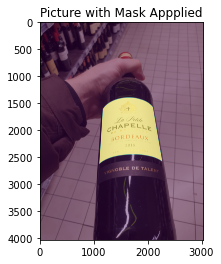

In [25]:
img = Image.open(X_train[0])
img = ImageOps.exif_transpose(img)
mask = Image.open(y_train[0]).convert("L")

print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask, dtype=np.bool).shape)

plt.imshow(img)
plt.imshow(mask, alpha=0.4)
plt.title('Picture with Mask Appplied')
plt.show()

In [14]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(1024, 768, interpolation=cv2.INTER_NEAREST), 
                     A.HorizontalFlip(), 
                     A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), 
                     A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(1024, 768, interpolation=cv2.INTER_NEAREST), 
                   A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)]
                  )

#datasets
train_set = WineDataset(X_train, y_train, mean, std, t_train, patch=False)
val_set = WineDataset(X_valid, y_valid, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)   

### Train
---

In [16]:

model = smp.DeepLabV3Plus('resnet34', encoder_weights='imagenet', classes=2, activation=None)


In [17]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [18]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [19]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device)
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'DeepLab-ResNet_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [21]:
max_lr = 1e-4
epoch = 30
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = train(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipykernel_21197/2650995839.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = mask.astype(np.bool)
100%|██████████| 6/6 [00:03<00:00,  1.90it/s]


Loss Decreasing.. inf >> 0.615 
Epoch:1/30.. Train Loss: 0.642.. Val Loss: 0.615.. Train mIoU:0.426.. Val mIoU: 0.516.. Train Acc:0.641.. Val Acc:0.707.. Time: 0.73m


100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


Loss Decreasing.. 0.615 >> 0.406 
Epoch:2/30.. Train Loss: 0.502.. Val Loss: 0.406.. Train mIoU:0.675.. Val mIoU: 0.792.. Train Acc:0.831.. Val Acc:0.897.. Time: 0.73m


100%|██████████| 6/6 [00:02<00:00,  2.01it/s]


Loss Decreasing.. 0.406 >> 0.199 
Epoch:3/30.. Train Loss: 0.314.. Val Loss: 0.199.. Train mIoU:0.839.. Val mIoU: 0.916.. Train Acc:0.926.. Val Acc:0.965.. Time: 0.72m


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


Loss Decreasing.. 0.199 >> 0.138 
saving model...
Epoch:4/30.. Train Loss: 0.178.. Val Loss: 0.138.. Train mIoU:0.901.. Val mIoU: 0.922.. Train Acc:0.957.. Val Acc:0.969.. Time: 0.72m


100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


Loss Decreasing.. 0.138 >> 0.075 
Epoch:5/30.. Train Loss: 0.110.. Val Loss: 0.075.. Train mIoU:0.936.. Val mIoU: 0.944.. Train Acc:0.973.. Val Acc:0.978.. Time: 0.72m


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


Loss Decreasing.. 0.075 >> 0.063 
Epoch:6/30.. Train Loss: 0.095.. Val Loss: 0.063.. Train mIoU:0.938.. Val mIoU: 0.951.. Train Acc:0.974.. Val Acc:0.980.. Time: 0.73m


100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


Loss Not Decrease for 1 time
Epoch:7/30.. Train Loss: 0.067.. Val Loss: 0.072.. Train mIoU:0.959.. Val mIoU: 0.952.. Train Acc:0.983.. Val Acc:0.980.. Time: 0.71m


100%|██████████| 6/6 [00:03<00:00,  1.95it/s]


Loss Decreasing.. 0.072 >> 0.069 
Epoch:8/30.. Train Loss: 0.056.. Val Loss: 0.069.. Train mIoU:0.966.. Val mIoU: 0.951.. Train Acc:0.986.. Val Acc:0.978.. Time: 0.72m


100%|██████████| 6/6 [00:03<00:00,  1.95it/s]


Loss Decreasing.. 0.069 >> 0.052 
Epoch:9/30.. Train Loss: 0.046.. Val Loss: 0.052.. Train mIoU:0.972.. Val mIoU: 0.964.. Train Acc:0.989.. Val Acc:0.985.. Time: 0.74m


100%|██████████| 6/6 [00:03<00:00,  1.97it/s]


Loss Decreasing.. 0.052 >> 0.048 
saving model...
Epoch:10/30.. Train Loss: 0.036.. Val Loss: 0.048.. Train mIoU:0.979.. Val mIoU: 0.959.. Train Acc:0.991.. Val Acc:0.984.. Time: 0.72m


100%|██████████| 6/6 [00:03<00:00,  1.91it/s]


Loss Decreasing.. 0.048 >> 0.044 
Epoch:11/30.. Train Loss: 0.038.. Val Loss: 0.044.. Train mIoU:0.974.. Val mIoU: 0.965.. Train Acc:0.990.. Val Acc:0.986.. Time: 0.71m


100%|██████████| 6/6 [00:03<00:00,  1.93it/s]


Loss Not Decrease for 2 time
Epoch:12/30.. Train Loss: 0.035.. Val Loss: 0.059.. Train mIoU:0.978.. Val mIoU: 0.962.. Train Acc:0.991.. Val Acc:0.984.. Time: 0.72m


100%|██████████| 6/6 [00:03<00:00,  1.94it/s]


Loss Decreasing.. 0.059 >> 0.043 
Epoch:13/30.. Train Loss: 0.028.. Val Loss: 0.043.. Train mIoU:0.982.. Val mIoU: 0.969.. Train Acc:0.993.. Val Acc:0.987.. Time: 0.72m


100%|██████████| 6/6 [00:03<00:00,  1.92it/s]


Loss Not Decrease for 3 time
Epoch:14/30.. Train Loss: 0.029.. Val Loss: 0.047.. Train mIoU:0.983.. Val mIoU: 0.963.. Train Acc:0.993.. Val Acc:0.985.. Time: 0.72m


100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


Loss Decreasing.. 0.047 >> 0.038 
Epoch:15/30.. Train Loss: 0.026.. Val Loss: 0.038.. Train mIoU:0.984.. Val mIoU: 0.969.. Train Acc:0.993.. Val Acc:0.987.. Time: 0.71m


100%|██████████| 6/6 [00:02<00:00,  2.00it/s]


Loss Not Decrease for 4 time
Epoch:16/30.. Train Loss: 0.022.. Val Loss: 0.053.. Train mIoU:0.987.. Val mIoU: 0.963.. Train Acc:0.995.. Val Acc:0.984.. Time: 0.72m


100%|██████████| 6/6 [00:03<00:00,  2.00it/s]


Loss Decreasing.. 0.053 >> 0.052 
Epoch:17/30.. Train Loss: 0.021.. Val Loss: 0.052.. Train mIoU:0.987.. Val mIoU: 0.960.. Train Acc:0.995.. Val Acc:0.982.. Time: 0.72m


100%|██████████| 6/6 [00:03<00:00,  1.86it/s]


Loss Decreasing.. 0.052 >> 0.043 
saving model...
Epoch:18/30.. Train Loss: 0.018.. Val Loss: 0.043.. Train mIoU:0.989.. Val mIoU: 0.966.. Train Acc:0.996.. Val Acc:0.987.. Time: 0.74m


100%|██████████| 6/6 [00:03<00:00,  1.95it/s]


Loss Not Decrease for 5 time
Epoch:19/30.. Train Loss: 0.019.. Val Loss: 0.045.. Train mIoU:0.988.. Val mIoU: 0.964.. Train Acc:0.995.. Val Acc:0.985.. Time: 0.71m


100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


Loss Decreasing.. 0.045 >> 0.040 
Epoch:20/30.. Train Loss: 0.020.. Val Loss: 0.040.. Train mIoU:0.988.. Val mIoU: 0.972.. Train Acc:0.995.. Val Acc:0.988.. Time: 0.73m


100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


Loss Not Decrease for 6 time
Epoch:21/30.. Train Loss: 0.018.. Val Loss: 0.058.. Train mIoU:0.989.. Val mIoU: 0.963.. Train Acc:0.996.. Val Acc:0.984.. Time: 0.72m


100%|██████████| 6/6 [00:02<00:00,  2.00it/s]


Loss Decreasing.. 0.058 >> 0.042 
Epoch:22/30.. Train Loss: 0.016.. Val Loss: 0.042.. Train mIoU:0.989.. Val mIoU: 0.971.. Train Acc:0.996.. Val Acc:0.988.. Time: 0.71m


100%|██████████| 6/6 [00:03<00:00,  1.98it/s]


Loss Decreasing.. 0.042 >> 0.038 
Epoch:23/30.. Train Loss: 0.015.. Val Loss: 0.038.. Train mIoU:0.990.. Val mIoU: 0.970.. Train Acc:0.996.. Val Acc:0.988.. Time: 0.73m


100%|██████████| 6/6 [00:02<00:00,  2.04it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 17.34 m


In [22]:
torch.save(model, 'DeepLabV3Plus-resnet34.pt')

In [23]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

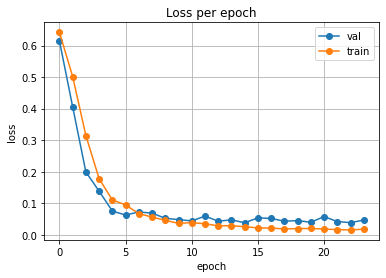

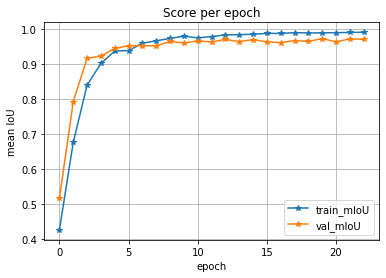

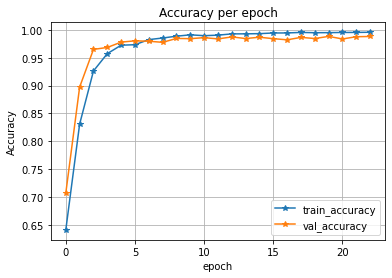

In [24]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [24]:
class WineTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.transform = transform
      
    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path[idx], cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
            
        mask = mask.astype(np.bool)
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(1024, 768, interpolation=cv2.INTER_NEAREST)
test_set = WineTestDataset(X_valid, y_valid, transform=t_test)

In [25]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [26]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [27]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

/tmp/ipykernel_14245/3966830550.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = mask.astype(np.bool)


In [28]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [29]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/17 [00:00<?, ?it/s]/tmp/ipykernel_14245/3966830550.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = mask.astype(np.bool)
100%|██████████| 17/17 [00:02<00:00,  5.93it/s]


In [30]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [31]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/17 [00:00<?, ?it/s]/tmp/ipykernel_14245/3966830550.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = mask.astype(np.bool)
100%|██████████| 17/17 [00:02<00:00,  6.29it/s]


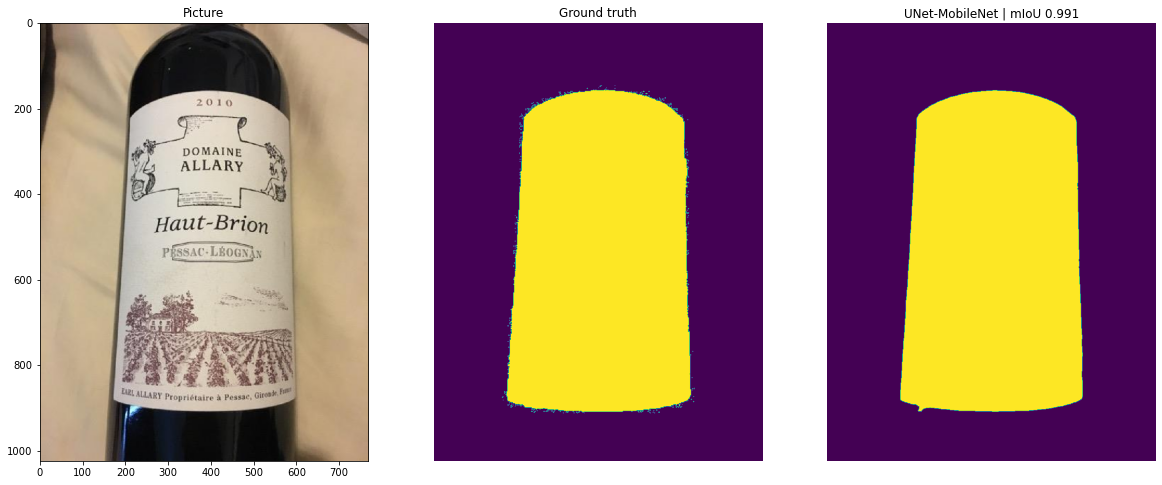

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture')

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

/tmp/ipykernel_14245/3966830550.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = mask.astype(np.bool)


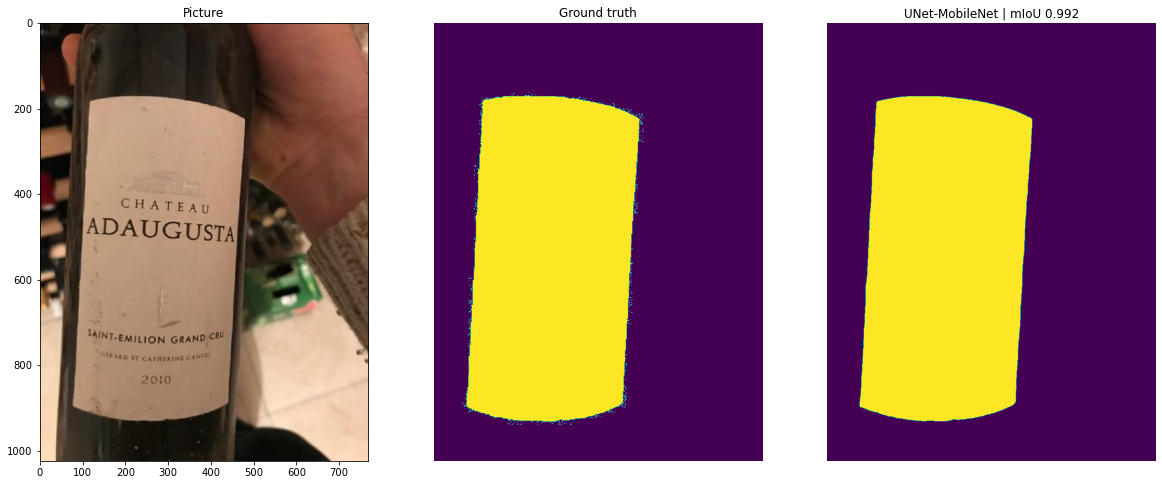

In [33]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture')

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

/tmp/ipykernel_14245/3966830550.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = mask.astype(np.bool)


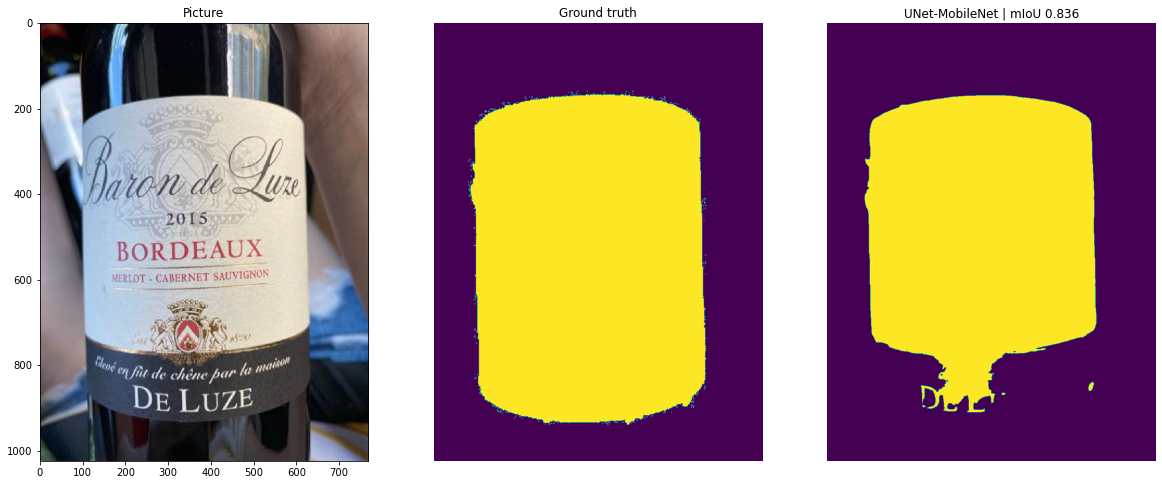

In [34]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture')

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()